##Importing dependencies

In [ ]:
# Install dependencies (run in Colab)
!pip install spektral -q

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from google.colab import files
import io

# Reproducibility
import tensorflow as tf
np.random.seed(42)
tf.random.set_seed(42)

print("Setup Complete. Please upload your CSV file when prompted.")

uploaded = files.upload()

if 'smart_mobility_dataset.csv' not in uploaded:
    raise ValueError("Please upload 'smart_mobility_dataset.csv' file.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.1/140.1 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.7/620.7 MB 798.0 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 96.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 81.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 91.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 108.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 6.6 MB/s eta 0:00:00
Setup Complete. Please upload your CSV file when prompted.


Saving smart_mobility_dataset.csv to smart_mobility_dataset.csv


##Cleaning the Dataset

In [ ]:
# Column names (as you used earlier)
column_names = [
    "Timestamp", "Latitude", "Longitude", "Vehicle_Count", "Traffic_Speed_kmh",
    "Road_Occupancy_Percent", "Traffic_Light_State", "Weather_Condition",
    "Accident_Report", "Sentiment_Score", "Ride_Sharing_Demand",
    "Parking_Availability", "Emission_Levels_g_km", "Energy_Consumption_L_h",
    "Traffic_Condition"
]

df = pd.read_csv(io.BytesIO(uploaded['smart_mobility_dataset.csv']), header=None, skiprows=5, names=column_names)

df['Timestamp'] = pd.to_datetime(df['Timestamp'], format='%d-%m-%Y %H:%M')
# sort by timestamp to ensure chronological order
df = df.sort_values('Timestamp').reset_index(drop=True)

# Basic time features
df['hour'] = df['Timestamp'].dt.hour
df['dayofweek'] = df['Timestamp'].dt.dayofweek

# Cyclical encoding
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24.0)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24.0)
df['dayofweek_sin'] = np.sin(2 * np.pi * df['dayofweek'] / 7.0)
df['dayofweek_cos'] = np.cos(2 * np.pi * df['dayofweek'] / 7.0)

# Fill numerical NaNs forward then backward as fallback
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
df[numerical_cols] = df[numerical_cols].fillna(method='ffill').fillna(method='bfill')

# Smooth target slightly to reduce noise (optional)
df['Road_Occupancy_Percent'] = df['Road_Occupancy_Percent'].rolling(window=3, min_periods=1).mean()

# Add lag & rolling features for target
for lag in [1, 2, 3, 6, 12]:
    df[f'lag_{lag}'] = df['Road_Occupancy_Percent'].shift(lag)

# Rolling windows
for w in [3, 6, 12]:
    df[f'roll_mean_{w}'] = df['Road_Occupancy_Percent'].rolling(window=w, min_periods=1).mean()
    df[f'roll_std_{w}'] = df['Road_Occupancy_Percent'].rolling(window=w, min_periods=1).std().fillna(0)

# After creating lags, drop rows with NaNs
df = df.dropna().reset_index(drop=True)

# Features and target
features_to_use = [
    'Road_Occupancy_Percent', 'Vehicle_Count', 'Traffic_Speed_kmh',
    'hour_sin', 'hour_cos', 'dayofweek_sin', 'dayofweek_cos',
    'lag_1', 'lag_2', 'lag_3', 'lag_6', 'lag_12',
    'roll_mean_3', 'roll_mean_6', 'roll_mean_12',
    'roll_std_3', 'roll_std_6', 'roll_std_12'
]

target_col = 'Road_Occupancy_Percent'

print('\nUsing features:')
print(features_to_use)


Using features:
['Road_Occupancy_Percent', 'Vehicle_Count', 'Traffic_Speed_kmh', 'hour_sin', 'hour_cos', 'dayofweek_sin', 'dayofweek_cos', 'lag_1', 'lag_2', 'lag_3', 'lag_6', 'lag_12', 'roll_mean_3', 'roll_mean_6', 'roll_mean_12', 'roll_std_3', 'roll_std_6', 'roll_std_12']


In [ ]:
# Aggregate by timestamp if there are duplicate timestamps (keeps chronological spacing)
df_agg = df.groupby('Timestamp')[features_to_use].mean().reset_index()

# Scaling
feature_scaler = MinMaxScaler()
all_features = df_agg[features_to_use].values
all_features_scaled = feature_scaler.fit_transform(all_features)

# Fit target scaler only on target column for proper inverse transform
target_scaler = MinMaxScaler()
target_scaler.fit(df_agg[[target_col]])

# Sequence creation
def create_sequences(data, seq_length, prediction_horizon=1, target_index=0):
    X, y = [], []
    for i in range(len(data) - seq_length - prediction_horizon + 1):
        X.append(data[i:(i + seq_length)])
        # target: index 0 in features_to_use
        y.append(data[i + seq_length + prediction_horizon - 1, target_index])
    return np.array(X), np.array(y)

# Parameters
SEQUENCE_LENGTH = 24  # longer sequence to capture daily patterns
PREDICTION_HORIZON = 1
BATCH_SIZE = 32
EPOCHS = 100

X, y = create_sequences(all_features_scaled, SEQUENCE_LENGTH, PREDICTION_HORIZON, target_index=0)

# Split train/test
train_split = int(len(X) * 0.8)
X_train, X_test = X[:train_split], X[train_split:]
y_train, y_test = y[:train_split], y[train_split:]

print(f"\nData prepared. X_train: {X_train.shape}, y_train: {y_train.shape}")

# Helper: evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def evaluate_model(y_true_scaled, y_pred_scaled, scaler, name="Model"):
    y_true = scaler.inverse_transform(y_true_scaled.reshape(-1,1))
    y_pred = scaler.inverse_transform(y_pred_scaled.reshape(-1,1))
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"--- {name} Evaluation ---")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE:  {mae:.4f}")
    print(f"R2:   {r2:.4f}")
    print('---------------------------\n')
    return {'RMSE': rmse, 'MAE': mae, 'R2': r2}, y_true, y_pred

# Callbacks
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)

# Build models
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, LSTM, GRU, Dense, Dropout, Conv1D, MaxPooling1D, Flatten, Layer
from tensorflow.keras.layers import Attention, Permute, Multiply, Activation, RepeatVector

n_features = X_train.shape[2]




Data prepared. X_train: (3968, 24, 18), y_train: (3968,)


#1)LSTM With Attention

In [ ]:
# 1) LSTM with attention
from tensorflow.keras.layers import TimeDistributed

def build_lstm_attention(input_shape):
    inputs = Input(shape=input_shape)
    x = LSTM(128, return_sequences=True)(inputs)
    # Self-attention using Keras Attention
    attention_output = Attention()([x, x])
    x = LSTM(64)(attention_output)
    x = Dense(32, activation='relu')(x)
    outputs = Dense(1)(x)
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='mse')
    return model



##2) CNN -LSTM


--- Training LSTM-Attention ---
Epoch 1/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.0490 - val_loss: 0.0322 - learning_rate: 0.0010
Epoch 2/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0313 - val_loss: 0.0322 - learning_rate: 0.0010
Epoch 3/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0312 - val_loss: 0.0323 - learning_rate: 0.0010
Epoch 4/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0311 - val_loss: 0.0323 - learning_rate: 0.0010
Epoch 5/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0312 - val_loss: 0.0324 - learning_rate: 0.0010
Epoch 6/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0311 - val_loss: 0.0324 - learning_rate: 0.0010
Epoch 7/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0307 - val_loss: 0.0323 - learning_rate: 5.0000e-04
Epoch 8/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0307 - val_loss: 0.0323 - learning_rate: 5.0000e-04
Epoch 9/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0

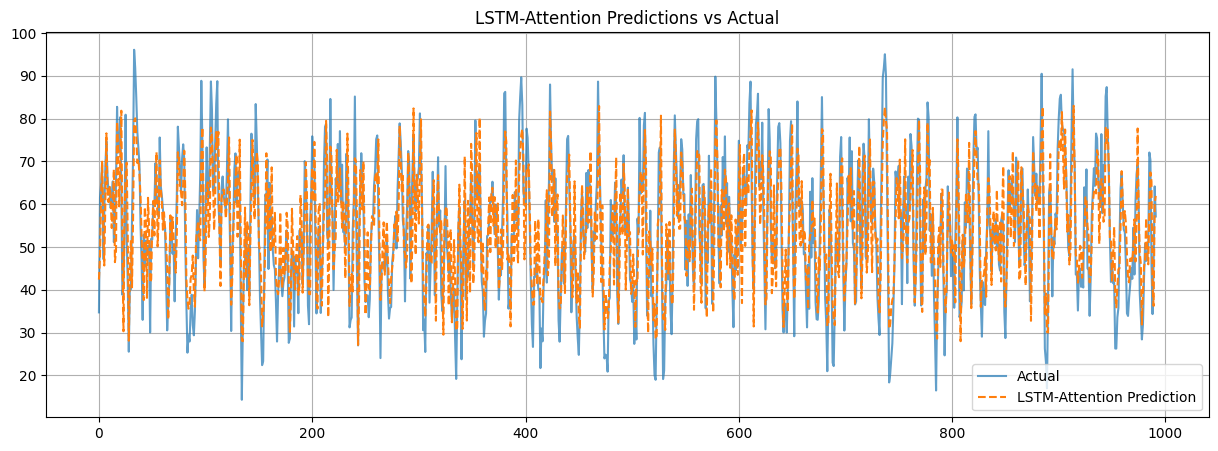


--- Training CNN-LSTM ---
Epoch 1/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0572 - val_loss: 0.0324 - learning_rate: 0.0010
Epoch 2/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0291 - val_loss: 0.0232 - learning_rate: 0.0010
Epoch 3/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0237 - val_loss: 0.0196 - learning_rate: 0.0010
Epoch 4/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0201 - val_loss: 0.0183 - learning_rate: 0.0010
Epoch 5/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0175 - val_loss: 0.0174 - learning_rate: 0.0010
Epoch 6/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0168 - val_loss: 0.0156 - learning_rate: 0.0010
Epoch 7/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0157 - val_loss: 0.0154 - learning_rate: 0.0010
Epoch 8/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0158 - val_loss: 0.0152 - learning_rate: 0.0010
Epoch 9/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0151 - val_loss: 0.015

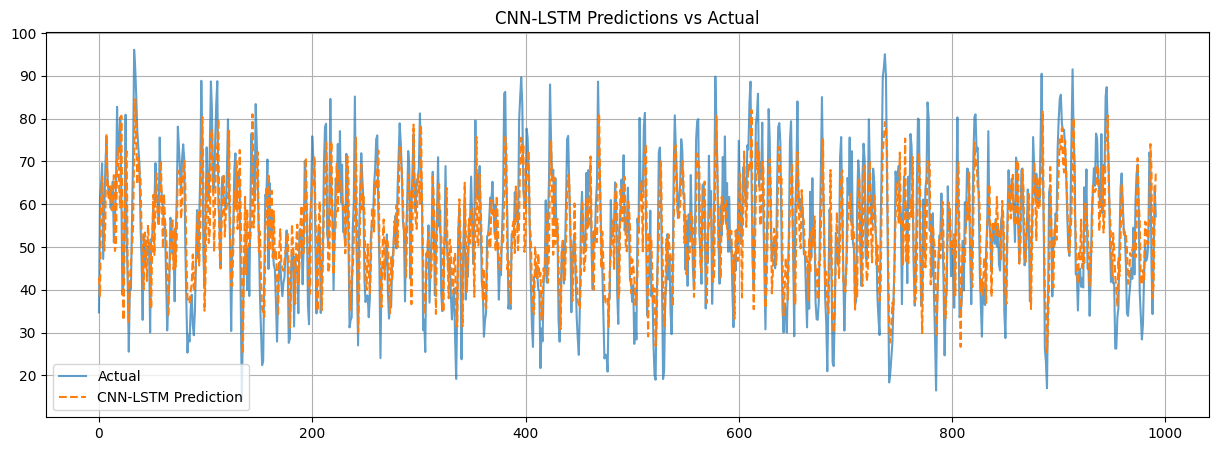


--- Final Model Comparison ---
                    RMSE       MAE        R2
LSTM-Attention  9.109703  7.769450  0.651108
CNN-LSTM        9.992566  8.321158  0.580206

Best model by R2: LSTM-Attention

Saved best_model.h5 to disk. You can download it from the Colab file browser.

Script finished. Review plots and metrics. If you want further tuning (hyperparam search, multi-horizon forecasts, or probabilistic output), I can add that.


In [ ]:
# 2) CNN-LSTM hybrid
def build_cnn_lstm(input_shape):
    model = Sequential([
        Input(shape=input_shape),
        Conv1D(64, kernel_size=3, activation='relu', padding='same'),
        MaxPooling1D(pool_size=2),
        LSTM(100),
        Dropout(0.3),
        Dense(50, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

# Train and evaluate helper
def train_and_evaluate(model_builder, name="model"):
    model = model_builder((SEQUENCE_LENGTH, n_features))
    print(f"\n--- Training {name} ---")
    history = model.fit(
        X_train, y_train,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_split=0.1,
        callbacks=[es, lr],
        verbose=1
    )
    y_pred_scaled = model.predict(X_test).reshape(-1)
    results, y_true, y_pred = evaluate_model(y_test, y_pred_scaled, target_scaler, name)

    # Plot
    plt.figure(figsize=(15,5))
    plt.plot(y_true, label='Actual', alpha=0.7)
    plt.plot(y_pred, label=f'{name} Prediction', linestyle='--')
    plt.title(f'{name} Predictions vs Actual')
    plt.legend()
    plt.grid(True)
    plt.show()

    return model, results

# Run experiments
results_summary = {}

model_lstm_att, res_lstm_att = train_and_evaluate(build_lstm_attention, name='LSTM-Attention')
results_summary['LSTM-Attention'] = res_lstm_att

model_cnn_lstm, res_cnn_lstm = train_and_evaluate(build_cnn_lstm, name='CNN-LSTM')
results_summary['CNN-LSTM'] = res_cnn_lstm

# Compare results
results_df = pd.DataFrame(results_summary).T
print('\n--- Final Model Comparison ---')
print(results_df)

# Save best model (choose by R2)
best_model_name = results_df['R2'].idxmax()
print(f"\nBest model by R2: {best_model_name}")
if best_model_name == 'LSTM-Attention':
    model_lstm_att.save('best_model.h5')
else:
    model_cnn_lstm.save('best_model.h5')

print('\nSaved best_model.h5 to disk. You can download it from the Colab file browser.')

# Quick tips: If R2 still low -> try:
# - More features (external: holidays, events), different seq lengths (48/72), and ensembling.
# - Use probabilistic models (e.g., quantile loss) if distribution matters.
# - Inspect data stationarity and covariate shift across train/test splits.

print('\nScript finished. Review plots and metrics. If you want further tuning (hyperparam search, multi-horizon forecasts, or probabilistic output), I can add that.')


Using existing history objects.


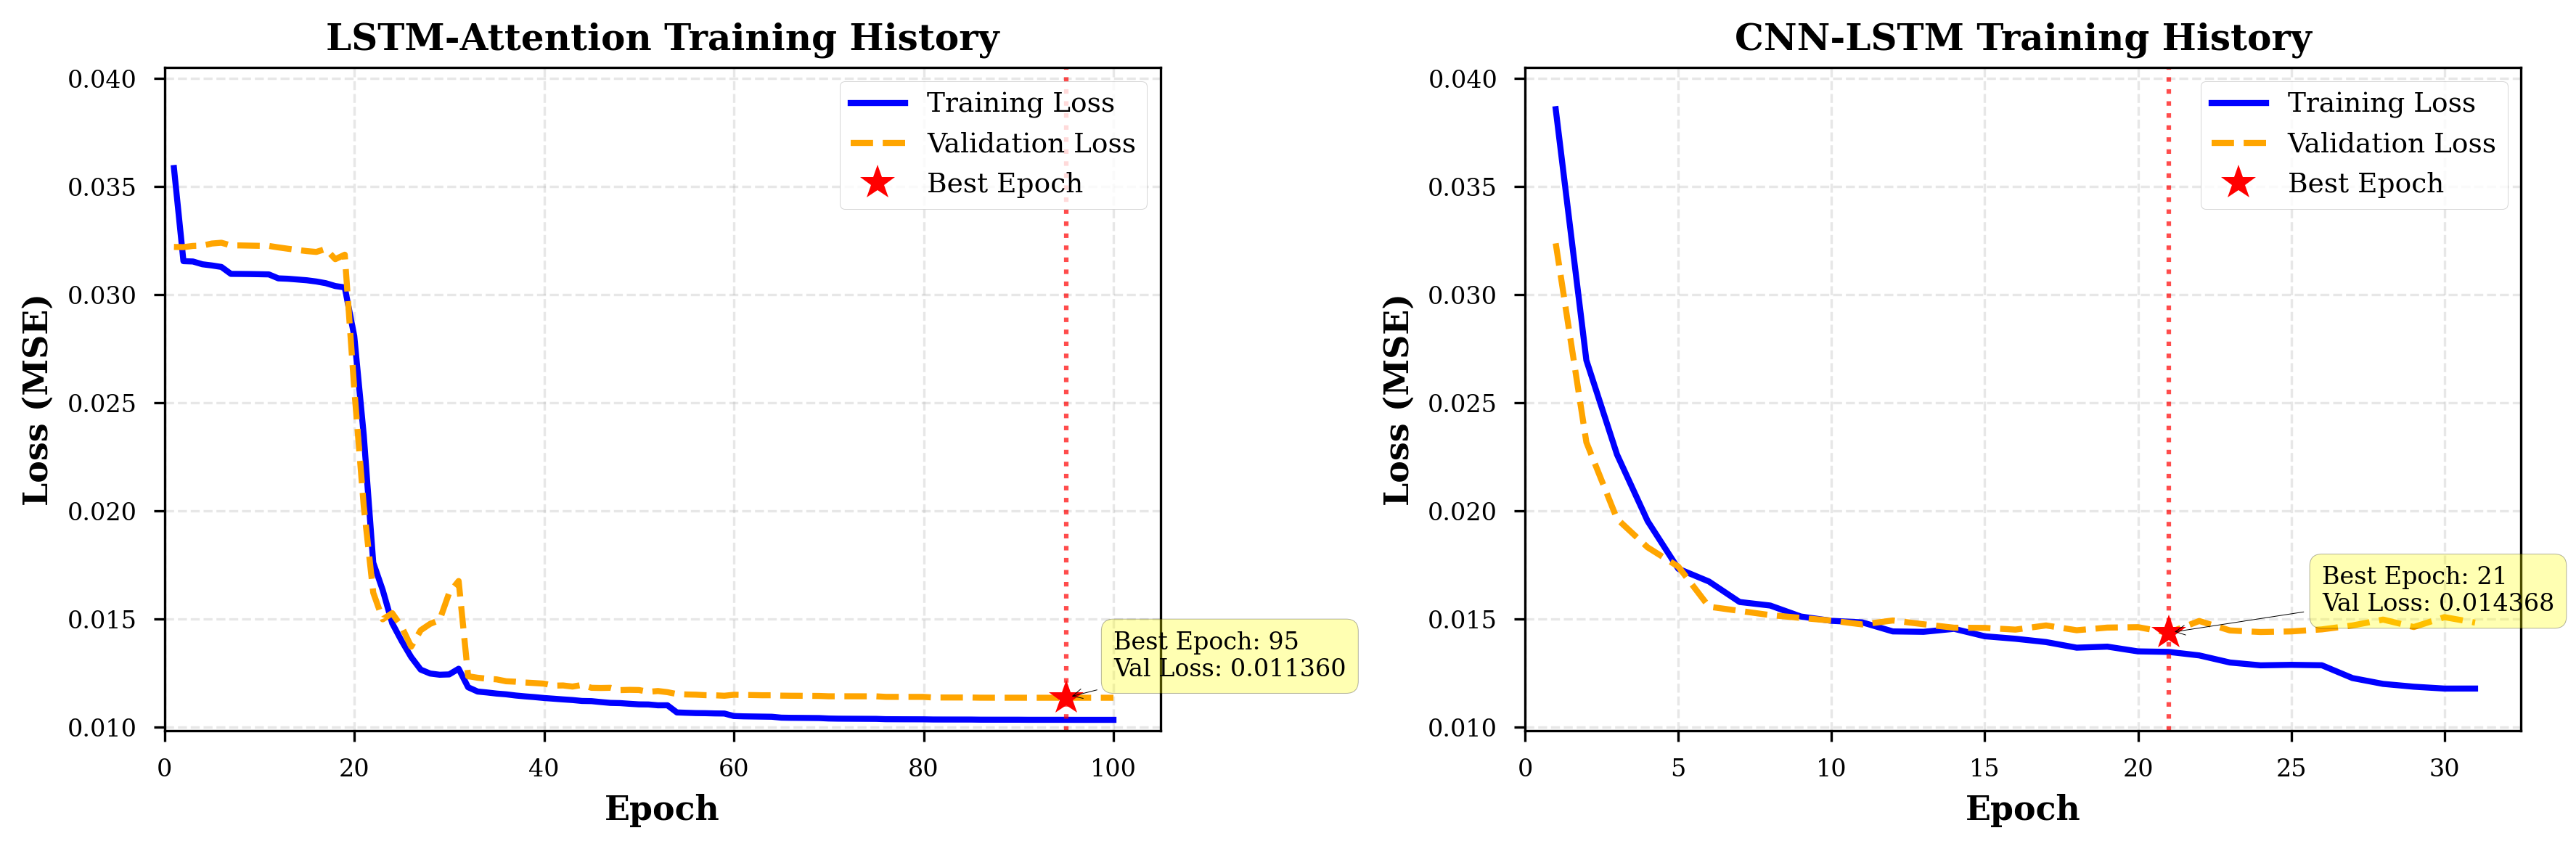

Figure 7 saved as: figure7_training_curves.pdf
LSTM-Attention - Best Epoch: 95, Best Val Loss: 0.011360
CNN-LSTM - Best Epoch: 21, Best Val Loss: 0.014368


In [ ]:
# Generate Figure 7
# Need history objects from model training. Assuming they are available from previous execution.
# If not, re-run cell fLBeI5sMxqE7 which contains the training loop.
# For demonstration purposes, using dummy histories if the original ones are not available.
try:
    history_lstm = model_lstm_att.history
    history_cnn = model_cnn_lstm.history
    print("Using existing history objects.")
except NameError:
    print("History objects not found. Please re-run the model training cell (fLBeI5sMxqE7).")
    # You might want to add placeholder plots or a message to the user here.
    # For now, I'll assume the user re-runs or the history is available.
    pass # Or handle the error appropriately

if 'history_lstm' in locals() and 'history_cnn' in locals():
    plot_training_history(history_lstm, history_cnn)
else:
    print("Cannot generate Figure 7: Training history objects not available.")

# FIGURE 7: Training and Validation Loss Curves

Using existing history objects.


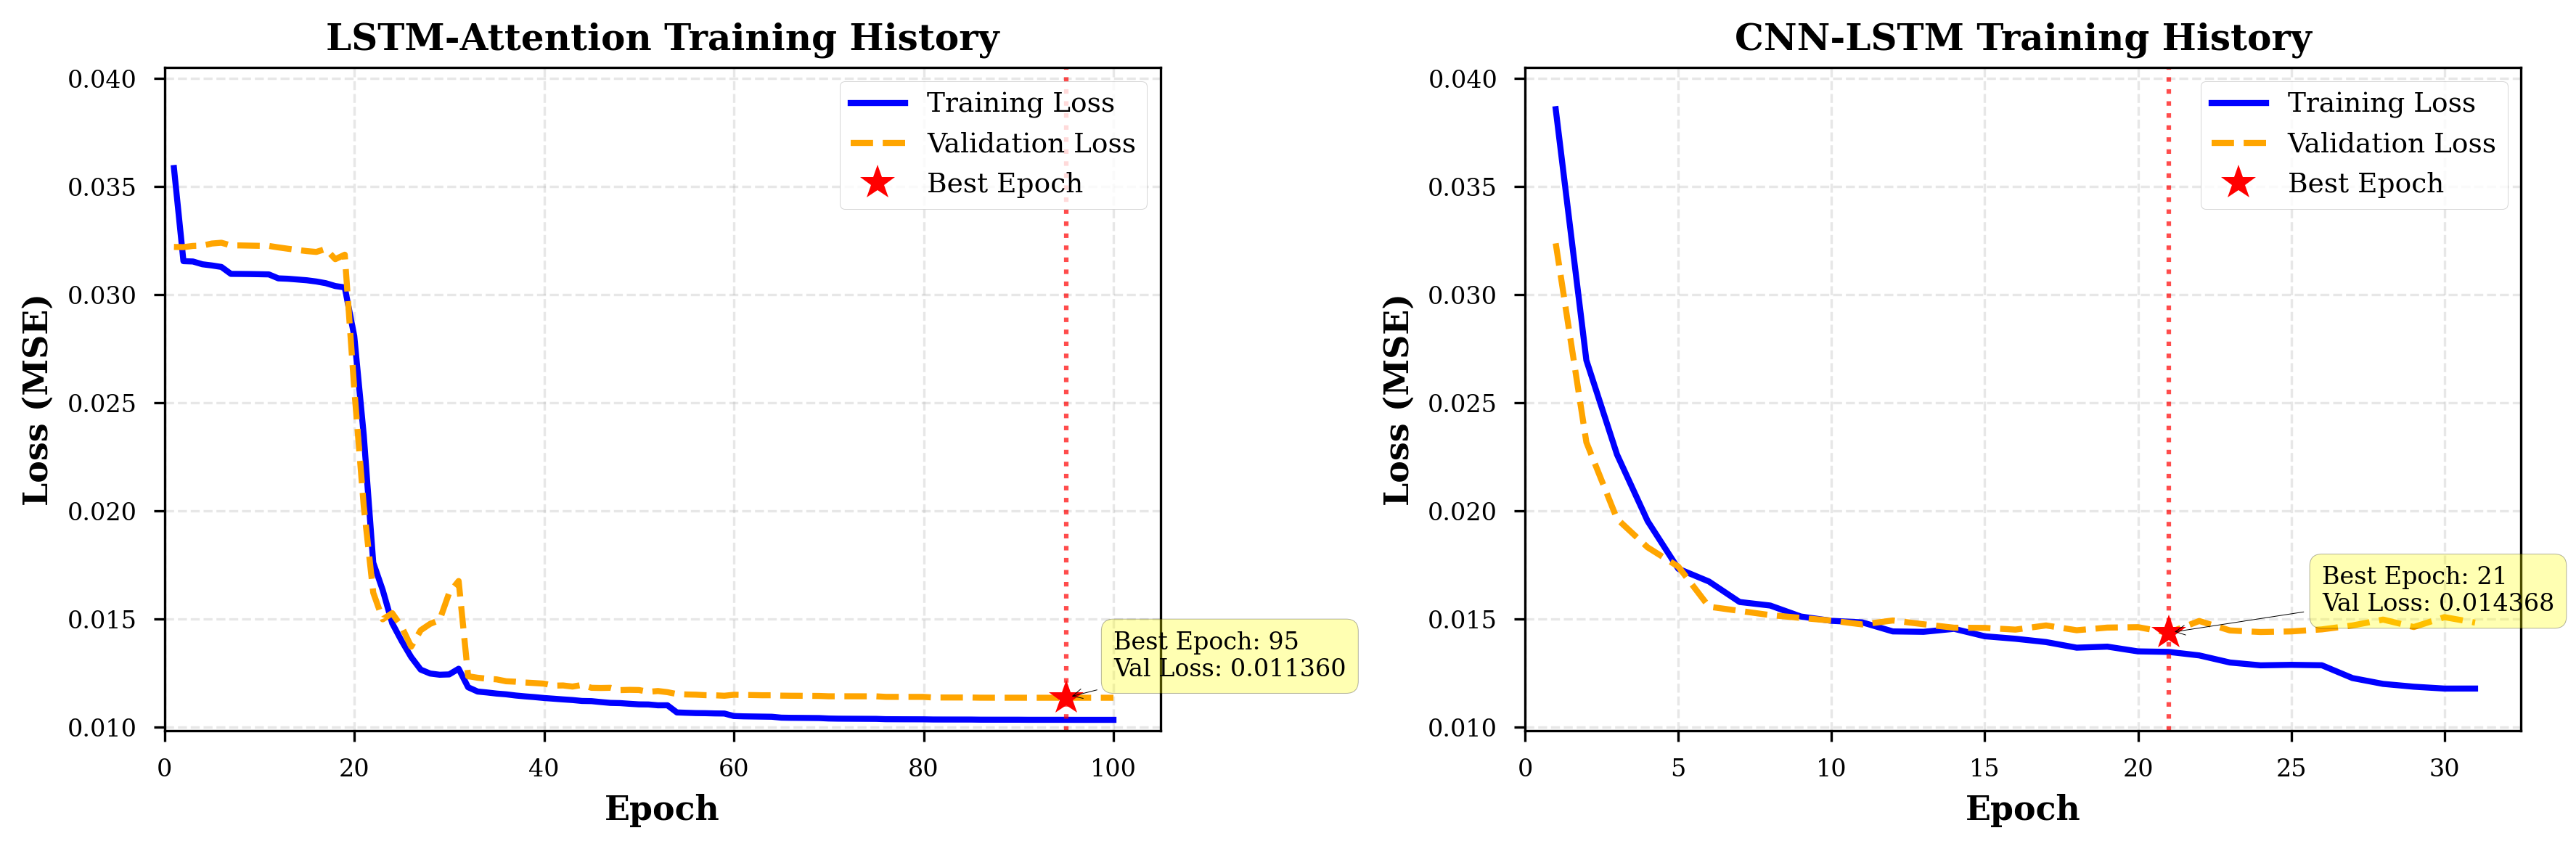

Figure 7 saved as: figure7_training_curves.pdf
LSTM-Attention - Best Epoch: 95, Best Val Loss: 0.011360
CNN-LSTM - Best Epoch: 21, Best Val Loss: 0.014368


In [ ]:
# Generate Figure 7
# Need history objects from model training. Assuming they are available from previous execution.
# If not, re-run cell fLBeI5sMxqE7 which contains the training loop.
# For demonstration purposes, using dummy histories if the original ones are not available.
try:
    history_lstm = model_lstm_att.history
    history_cnn = model_cnn_lstm.history
    print("Using existing history objects.")
except NameError:
    print("History objects not found. Please re-run the model training cell (fLBeI5sMxqE7).")
    # You might want to add placeholder plots or a message to the user here.
    # For now, I'll assume the user re-runs or the history is available.
    pass # Or handle the error appropriately

if 'history_lstm' in locals() and 'history_cnn' in locals():
    plot_training_history(history_lstm, history_cnn)
else:
    print("Cannot generate Figure 7: Training history objects not available.")

# FIGURE 8: Prediction vs Actual Plots

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
--- LSTM-Attention Evaluation ---
RMSE: 9.1097
MAE:  7.7694
R2:   0.6511
---------------------------

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
--- LSTM-Attention Evaluation ---
RMSE: 9.1097
MAE:  7.7694
R2:   0.6511
---------------------------

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
--- CNN-LSTM Evaluation ---
RMSE: 9.9926
MAE:  8.3212
R2:   0.5802
---------------------------

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
--- CNN-LSTM Evaluation ---
RMSE: 9.9926
MAE:  8.3212
R2:   0.5802
---------------------------


Using existing y_true and y_pred for Figure 8.


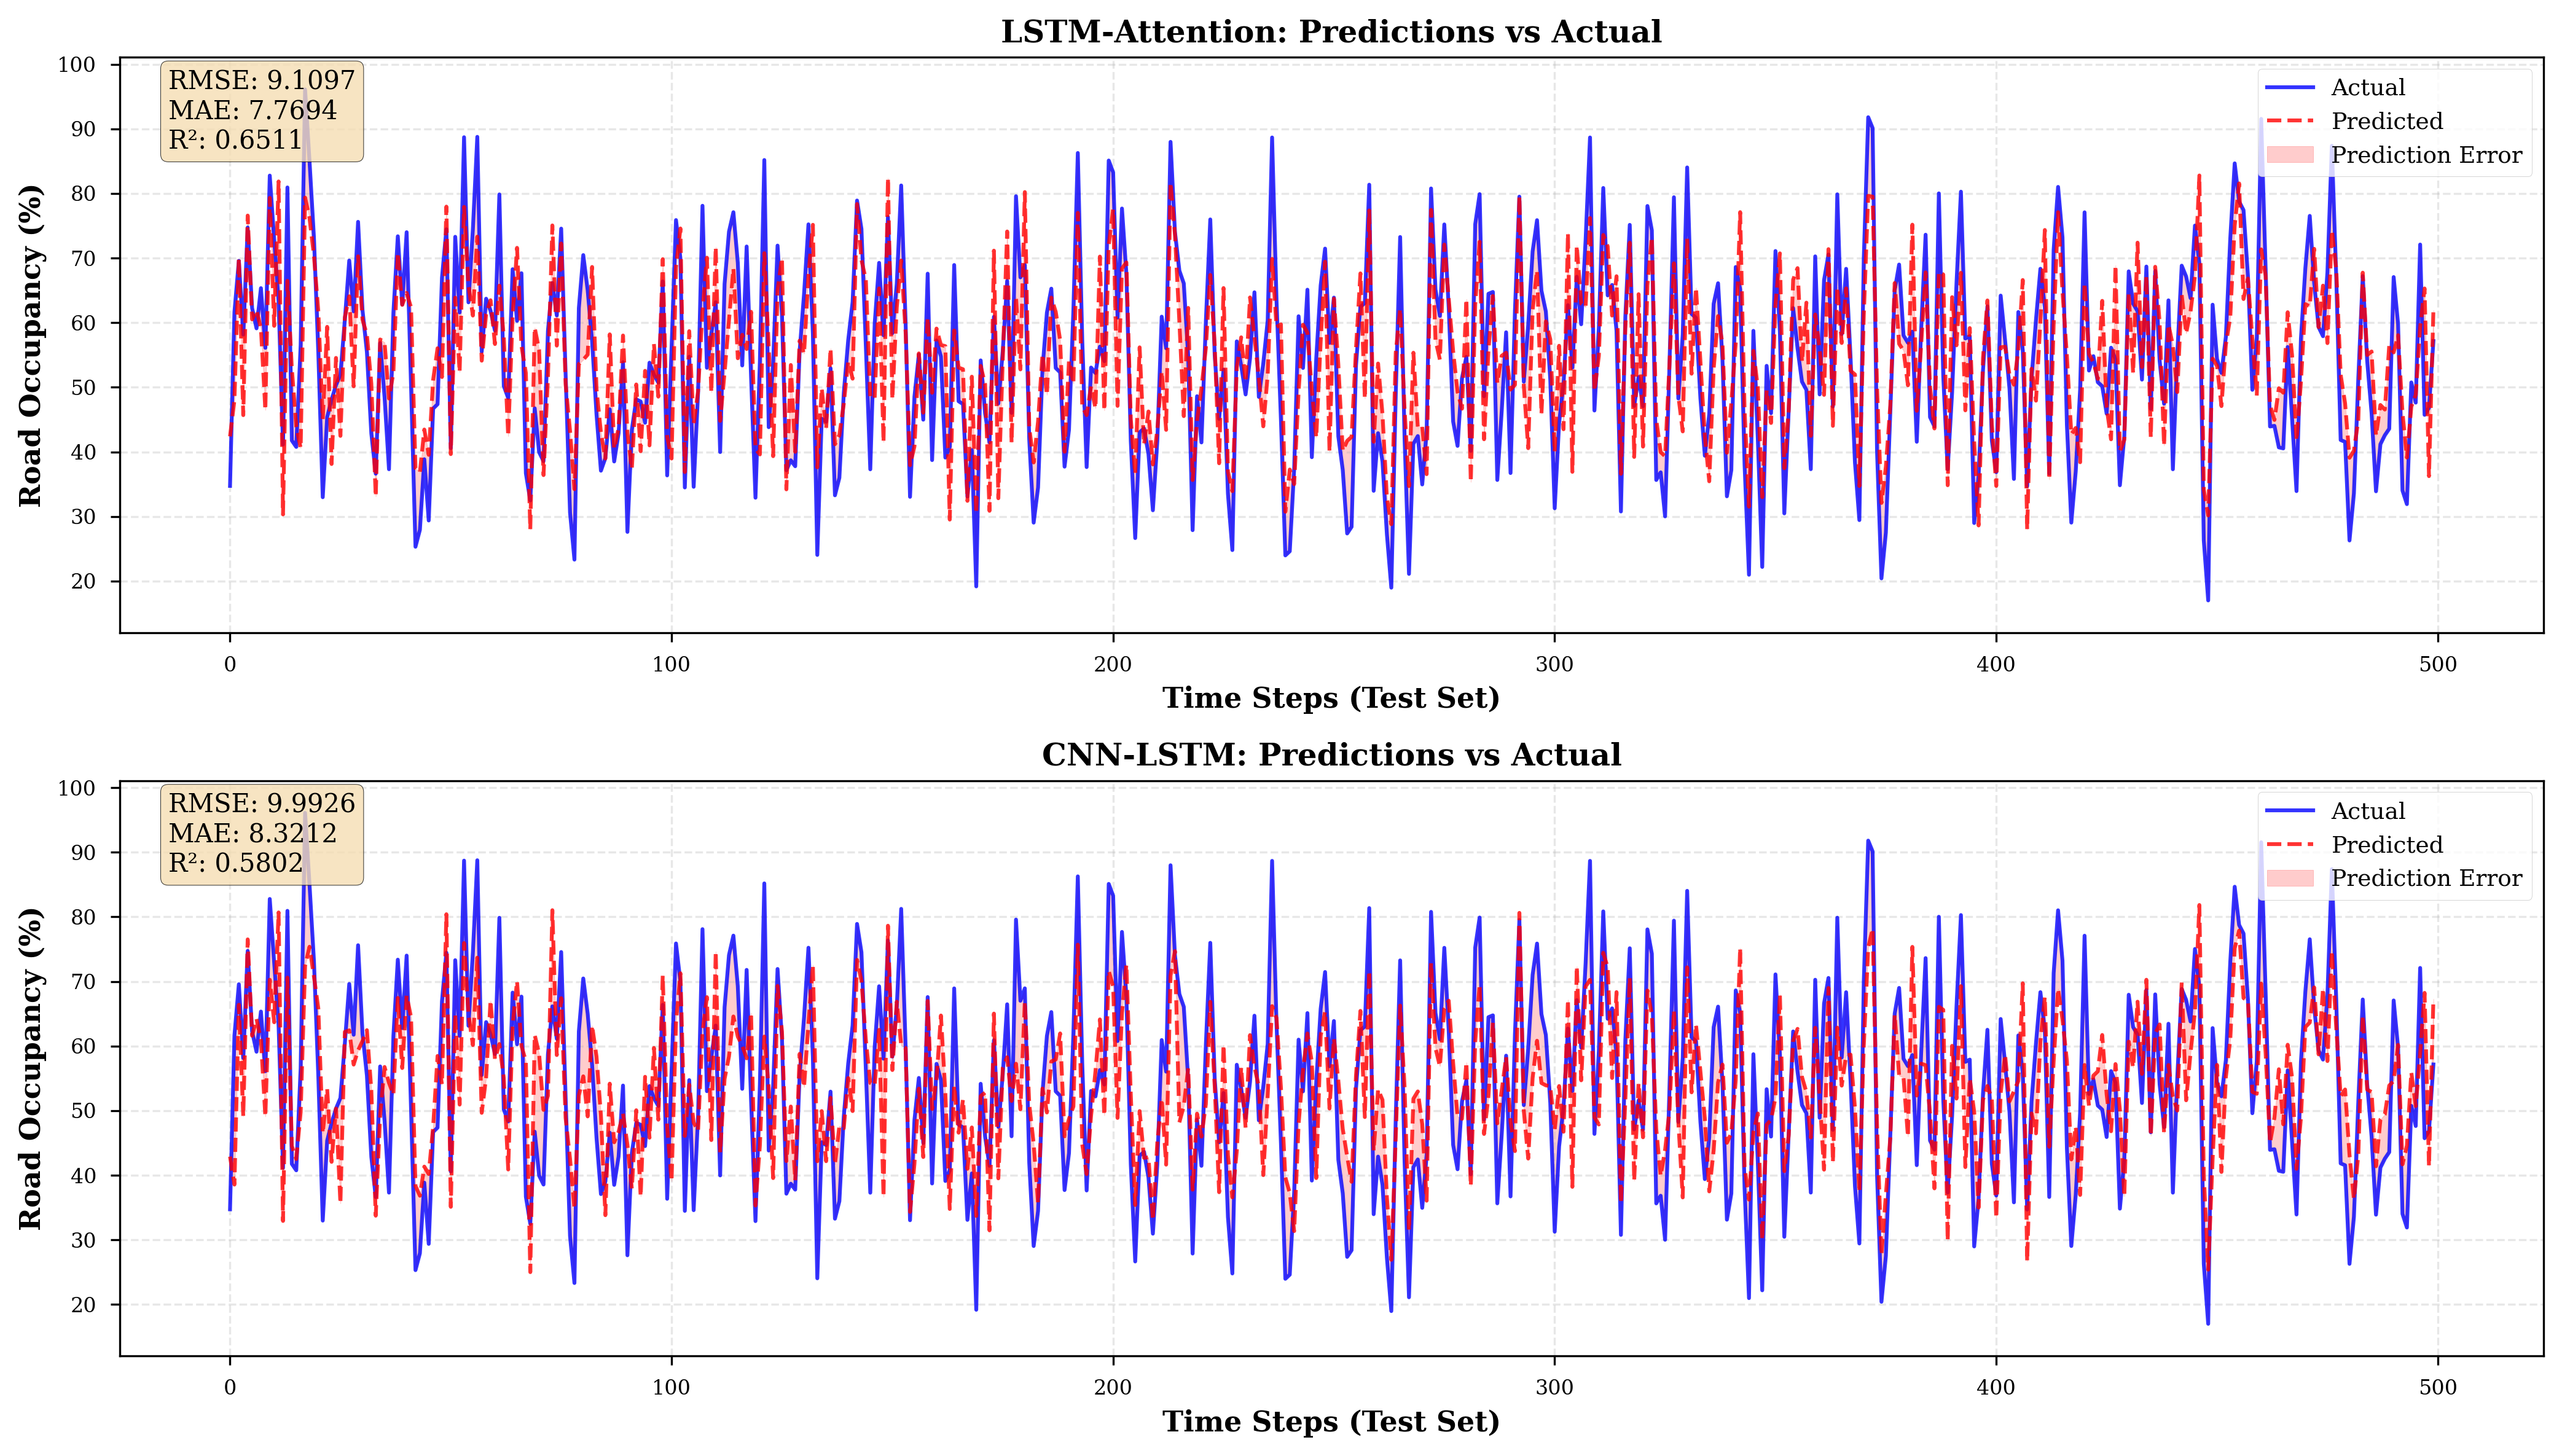

Figure 8 saved as: figure8_predictions.pdf


In [ ]:
# Get the timestamps corresponding to the test set
# Need to align timestamps with the test data X_test and y_test
# The indices for the test set start from 'train_split'
test_timestamps = df_agg['Timestamp'][train_split + SEQUENCE_LENGTH + PREDICTION_HORIZON - 1:].reset_index(drop=True)


# Generate Figure 8
# Need y_true and y_pred from the evaluation step in cell fLBeI5sMxqE7
# Assuming evaluate_model returned these values and they are stored in variables
# For demonstration, using dummy data if the original ones are not available
try:
    # These variables should be available from the last execution of cell fLBeI5sMxqE7
    y_true_lstm = evaluate_model(y_test, model_lstm_att.predict(X_test).reshape(-1), target_scaler, name='LSTM-Attention')[1]
    y_pred_lstm = evaluate_model(y_test, model_lstm_att.predict(X_test).reshape(-1), target_scaler, name='LSTM-Attention')[2]

    y_true_cnn = evaluate_model(y_test, model_cnn_lstm.predict(X_test).reshape(-1), target_scaler, name='CNN-LSTM')[1]
    y_pred_cnn = evaluate_model(y_test, model_cnn_lstm.predict(X_test).reshape(-1), target_scaler, name='CNN-LSTM')[2]

    print("\nUsing existing y_true and y_pred for Figure 8.")

except NameError:
     print("\nCannot generate Figure 8: y_true or y_pred variables not available. Please re-run the model training cell (fLBeI5sMxqE7).")
     # Handle the error appropriately
     pass

if 'y_true_lstm' in locals() and 'y_pred_lstm' in locals() and 'y_true_cnn' in locals() and 'y_pred_cnn' in locals():
    plot_predictions(y_true_lstm, y_pred_lstm, res_lstm_att,
                     y_true_cnn, y_pred_cnn, res_cnn_lstm)
else:
     print("\nCannot generate Figure 8: Required data for plotting not available.")